In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/My Drive/Faculdade/Mackenzie/TCC/")
!pwd

/content/drive/My Drive/Faculdade/Mackenzie/TCC


In [ ]:
!pip install scikit-learn glob2 tqdm pesq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from tqdm import tqdm
from pesq import pesq
import matplotlib.pyplot as plt

# Definir o nível de log do TensorFlow para ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from utils import load_wav, generate_white_gaussian_noise, add_white_gaussian_noise, undersample_signal_with_antialiasing, somar_sinais, calculate_snr

In [ ]:
def get_sounds_from_folder(path, pattern):
    max_depth = 3  # replace with the maximum depth of subfolders to search

    sound_list = []

    for root, dirs, files in os.walk(path):
        depth = root[len(path) + len(os.path.sep):].count(os.path.sep)
        if depth < max_depth:
            for file in files:
                if file.endswith(pattern):#or file.endswith('.bin'):
                    wav_path = os.path.join(root, file)
                    sound_list.append(wav_path)
    
    return sound_list

In [ ]:
!cat utils.py

from scipy.signal import butter, filtfilt, resample
import scipy.io.wavfile as wavfile
import numpy as np
import os

def get_sounds_from_folder(path, pattern):
    max_depth = 3  # replace with the maximum depth of subfolders to search

    sound_list = []

    for root, dirs, files in os.walk(path):
        depth = root[len(path) + len(os.path.sep):].count(os.path.sep)
        if depth < max_depth:
            for file in files:
                if file.endswith(pattern):#or file.endswith('.bin'):
                    wav_path = os.path.join(root, file)
                    sound_list.append(wav_path)
    
    return sound_list

def my():
    pass

def load_wav(filename, debug=False):
    # Load the WAV file
    sample_rate, data = wavfile.read(filename)
    
    if debug==True:
        print(np.max(data))
        print(np.min(data))

    # Normalize the data to float32 values between -1 and 1
    normalized_sound = np.float32(data)/ 32767.0
    
    if debug==True:
        print(np.max(

In [ ]:
base_shape_size = 6144
noise_files_dir = './ESC-50-master/ESC-50-master/audio/'
clean_files = get_sounds_from_folder('./Base/Base/', 'clean.wav')
noise_files = os.listdir(noise_files_dir)

In [ ]:
# Load clean sounds

clean_sounds = np.empty((1, base_shape_size), np.float32)

for clean_file in tqdm(clean_files[:10]):
    clean_sound = load_wav(clean_file)
    clean_sound = clean_sound[:len(clean_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size)
    clean_sounds = np.append(clean_sounds, clean_sound, axis=0)

# Verificar quais amostras da primeira dimensão têm valores fora do intervalo [-1, 1]
condicao = np.logical_or(clean_sounds > 1., clean_sounds < -1.)
# Verificar se há algum valor NaN
condicao_nan = np.isnan(clean_sounds)
# Verificar se há alguma condição verdadeira em qualquer uma das duas condições
condicao_final = np.logical_or(condicao, condicao_nan)
# Verificar se alguma condição é verdadeira em cada linha
linhas_invalidas = np.any(condicao_final, axis=1)

# Remover as amostras que atendem à condição
clean_sounds = clean_sounds[~linhas_invalidas]

100%|██████████| 10/10 [00:00<00:00, 388.29it/s]


In [ ]:
# Load noisy sounds

noise_sounds = []

for noise_file in tqdm(noise_files[:10]):
    noise_sound = load_wav(os.path.join(noise_files_dir, noise_file))
    noise_sound_under = undersample_signal_with_antialiasing(noise_sound, 44100, 8000)
    noise_sound_under = noise_sound_under[base_shape_size:base_shape_size*3]
    noise_sound_under = noise_sound_under.reshape(-1, base_shape_size)

    # Verificar quais amostras da primeira dimensão têm valores maiores que 1
    condicao = np.logical_or(noise_sound_under > 1, noise_sound_under < -1, np.isnan(noise_sound_under)).any(axis=1)
    # Remover as amostras que atendem à condição
    array_filtrado = clean_sound[np.logical_not(condicao)]

    noise_sounds.append(array_filtrado)

noise_sounds = np.array(noise_sounds).reshape(-1, base_shape_size)

# Verificar quais amostras da primeira dimensão têm valores fora do intervalo [-1, 1]
condicao = np.logical_or(noise_sounds > 1., noise_sounds < -1.)
# Verificar se há algum valor NaN
condicao_nan = np.isnan(noise_sounds)
# Verificar se há alguma condição verdadeira em qualquer uma das duas condições
condicao_final = np.logical_or(condicao, condicao_nan)
# Verificar se alguma condição é verdadeira em cada linha
linhas_invalidas = np.any(condicao_final, axis=1)

# Remover as amostras que atendem à condição
noise_sounds = noise_sounds[~linhas_invalidas]

100%|██████████| 10/10 [00:00<00:00, 17.15it/s]


In [ ]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files
        
    def normalize_array(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        normalized_array = (array - min_val) / (max_val - min_val)
        normalized_array = normalized_array * 2 - 1
        return normalized_array

    def generate_sample_pesq(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                sr = np.random.randint(0, 60, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
                noisy_sound = self.normalize_array(noisy_sound)
                sound = self.normalize_array(sound)
                
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(5, 30, size=(1,)[0]))
                noisy_sound = self.normalize_array(noisy_sound)
    
                # Calcula a nota PESQ
                try:
                    pesq_score = pesq(8000, sound, noisy_sound, 'nb')
                except:
                    continue

                valor_min = -0.6
                valor_max = 4.6
                pesq_score = (pesq_score - valor_min) / (valor_max - valor_min)
                
                # Formata dados para treinamento
                original_sound = sound.reshape((base_shape_size, 1))
                d_sound = noisy_sound.reshape((base_shape_size, 1))
                
                merged_array = np.concatenate((original_sound, d_sound), axis=1)
                
                # Adiciona o exemplo ao lote de treinamento
                x_train.append(merged_array)
                y_train.append(pesq_score)
            
            yield np.array(x_train), np.array(y_train)
            
    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x1_train = []
            x2_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                sr = np.random.randint(-5, 60, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
                noisy_sound = self.normalize_array(noisy_sound)
                sound = self.normalize_array(sound)

                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(5, 30, size=(1,)[0]))
                noisy_sound = self.normalize_array(noisy_sound)
    
                # Calcula a nota PESQ
                pesq_score = 1.0
                
                # Formata dados para treinamento
                original_sound = sound.reshape((base_shape_size, 1))
                d_sound = noisy_sound.reshape((256, 24, 1))
                
#                 merged_array = np.concatenate((original_sound, d_sound), axis=1)
                
                # Adiciona o exemplo ao lote de treinamento
                x1_train.append(d_sound)
                x2_train.append(original_sound)
                y_train.append(pesq_score)
            
            yield [np.array(x1_train), np.array(x2_train)], np.array(y_train)

    def generate_sample_pre(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x1_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                sr = np.random.randint(-5, 60, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
                noisy_sound = self.normalize_array(noisy_sound)
                sound = self.normalize_array(sound)
                
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(5, 30, size=(1,)[0]))
                noisy_sound = self.normalize_array(noisy_sound)
                
                # Formata dados para treinamento
                original_sound = sound.reshape((base_shape_size, 1))
                d_sound = noisy_sound.reshape((256, 24, 1))
                
                # Adiciona o exemplo ao lote de treinamento
                x1_train.append(d_sound)
                y_train.append(original_sound)
            
            yield np.array(x1_train), np.array(y_train)

In [ ]:
data_generator_train = DataGenerator(clean_sounds, noise_sounds)

In [ ]:
X, Y = next(data_generator_train.generate_sample_pre(batch_size=2))

In [ ]:
X.reshape(-1, 6144, 1).shape

(2, 6144, 1)

In [ ]:
Y.shape

(2, 6144, 1)

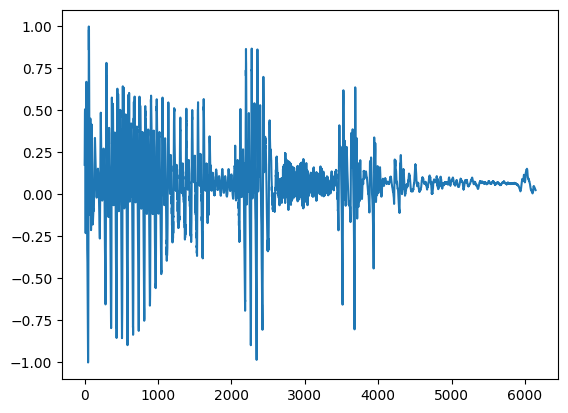

In [ ]:
import matplotlib.pyplot as plt

plt.plot(Y[0])

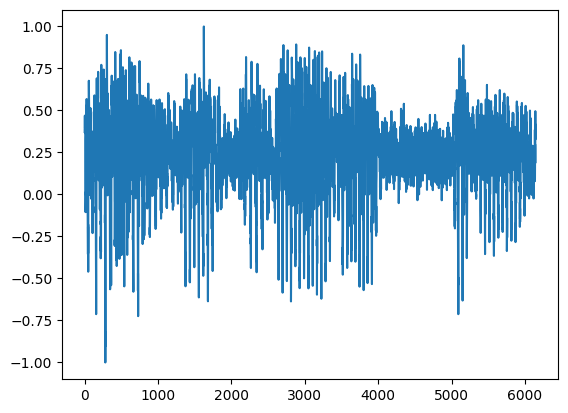

In [ ]:
plt.plot(X.reshape(-1, 6144, 1)[0])